# Setup env

In [ ]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Let's view the data 

In [ ]:
data = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')

**We are given the age, number of days the patient can survive and the extent of resection [resection means The complete removal of some brain tumors]**

In [ ]:
data.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


**let's drop all the nan from the data**

In [ ]:
data = data.dropna()

In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

**Here we are making 3 categories based on the days that the patient survived**

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# days start interval
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 300,  # 300-450
    'LONG' : 450, # 450 and more
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Volumetric analysis 

**Now we will do the volumetric ananlysis of the brain tumors to use as features for our model that will predict the survivability of the patient**

In [ ]:
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

total count: 1264556


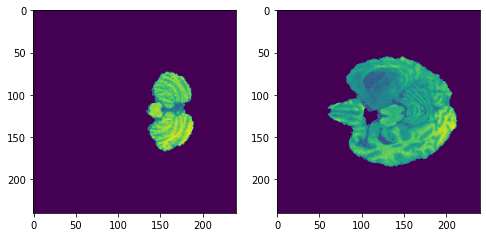

In [ ]:
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [ ]:
import csv

csv_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            #print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection


In [ ]:
def getListAgeDays(id_list):
    x_val = []
    y_val = []
    for i in id_list:
        if (i not in age_dict):
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        x_val.append(merged) 
        if (days_dict[i] < 250):
            y_val.append([1,0,0])
        elif (days_dict[i] >= 250 and days_dict[i] < 450):
            y_val.append([0,1,0])
        else:
            y_val.append([0,0,1])
            
    return np.array(x_val), np.array(y_val)

X_all, y_all = getListAgeDays(train_and_test_ids)

print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df.head()

X_test: (118, 4)


,age,NECROTIC/CORE,EDEMA,ENHANCING,short,medium,long
0,54.915,0.002438,0.045368,0.005153,0.0,1.0,0.0
1,57.000,0.015202,0.039171,0.019636,0.0,0.0,1.0
2,60.000,0.004592,0.027417,0.030548,0.0,0.0,1.0
3,83.649,0.039530,0.048636,0.025146,0.0,1.0,0.0
4,60.019,0.000448,0.018200,0.007183,0.0,1.0,0.0


**We round off the ages of every person in the data**

In [ ]:
df['age'] = df['age'].apply(np.floor)

**Here we normalize the data performing min-max scaling into range [0, 1]**

In [ ]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
display(df)

,age normalised,NECROTIC/CORE,EDEMA,ENHANCING
0,0.460631,0.060053,0.330630,0.105513
1,0.496066,0.374441,0.283556,0.406350
2,0.547051,0.113117,0.194263,0.633018
3,0.948964,0.973691,0.355460,0.520813
4,0.547373,0.011033,0.124241,0.147677
...,...,...,...,...
113,1.000000,0.337023,0.507990,0.673251
114,0.795687,0.207157,0.222702,0.605692
115,0.779440,0.037349,0.208887,0.115095
116,0.807277,0.383568,0.179196,0.338549


**Train test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


# SVM classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",svc.score(X_test,y_test_multi))

Model accuracy score : 0.5000
Cross validation: Train Score: 0.5216374269005847
Cross validation: Test Score: 0.5


**model metrics**

In [ ]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      0.11      0.18         9
           2       0.45      0.90      0.60        10

    accuracy                           0.50        24
   macro avg       0.65      0.47      0.45        24
weighted avg       0.58      0.50      0.44        24



In [ ]:
pred = list()
for y in y_pred:
    if y== 0:
        pred.append('severe')
    if y == 1:
        pred.append('medium')
    else:
        pred.append('early')

# Predictions

**our model outputs the severity of the tumor which also tells us the survivability of our patient**

In [ ]:
pred

['early',
 'early',
 'early',
 'early',
 'early',
 'medium',
 'early',
 'early',
 'early',
 'early',
 'early',
 'severe',
 'early',
 'early',
 'severe',
 'early',
 'early',
 'early',
 'early',
 'early',
 'early',
 'early',
 'medium',
 'early',
 'early',
 'early']